## Assignment_Clustering_EastWestAirlines

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.cm as cm
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score as sil, calinski_harabasz_score as chs, silhouette_samples

# Supressing Warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\PRASAD\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Importing dataset
data = pd.read_excel('EastWestAirlines.xlsx',sheet_name='data')

# Column rename.
data.rename(columns={'ID#':'ID', 'Award?':'Award'}, inplace=True)

#Set ID as Index Column
data.set_index('ID',inplace=True)
data.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0
2,19244,0,1,1,1,215,2,0,0,6968,0
3,41354,0,1,1,1,4123,4,0,0,7034,0
4,14776,0,1,1,1,500,1,0,0,6952,0
5,97752,0,4,1,1,43300,26,2077,4,6935,1


#### Data Exploration

In [3]:
data.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
count,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 1 to 4021
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award              3999 non-null   int64
dtypes: int64(11)
memory usage: 374.9 KB


In [5]:
# different cc_miles have different max values.
# so, we want to check what values these columns can take

print('unique_cc1',data.cc1_miles.unique())
print('unique_cc2',data.cc2_miles.unique())
print('unique_cc3',data.cc3_miles.unique())

unique_cc1 [1 4 3 2 5]
unique_cc2 [1 2 3]
unique_cc3 [1 3 2 4 5]


In [6]:
# checking the data for any missing/ na values
data.isnull().sum()

Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award                0
dtype: int64

In [7]:
# Additionally we check the data for any duplicate value
data.duplicated().sum()

1

In [8]:
data[data.duplicated()]

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
3899,1000,0,1,1,1,0,0,0,0,1597,0


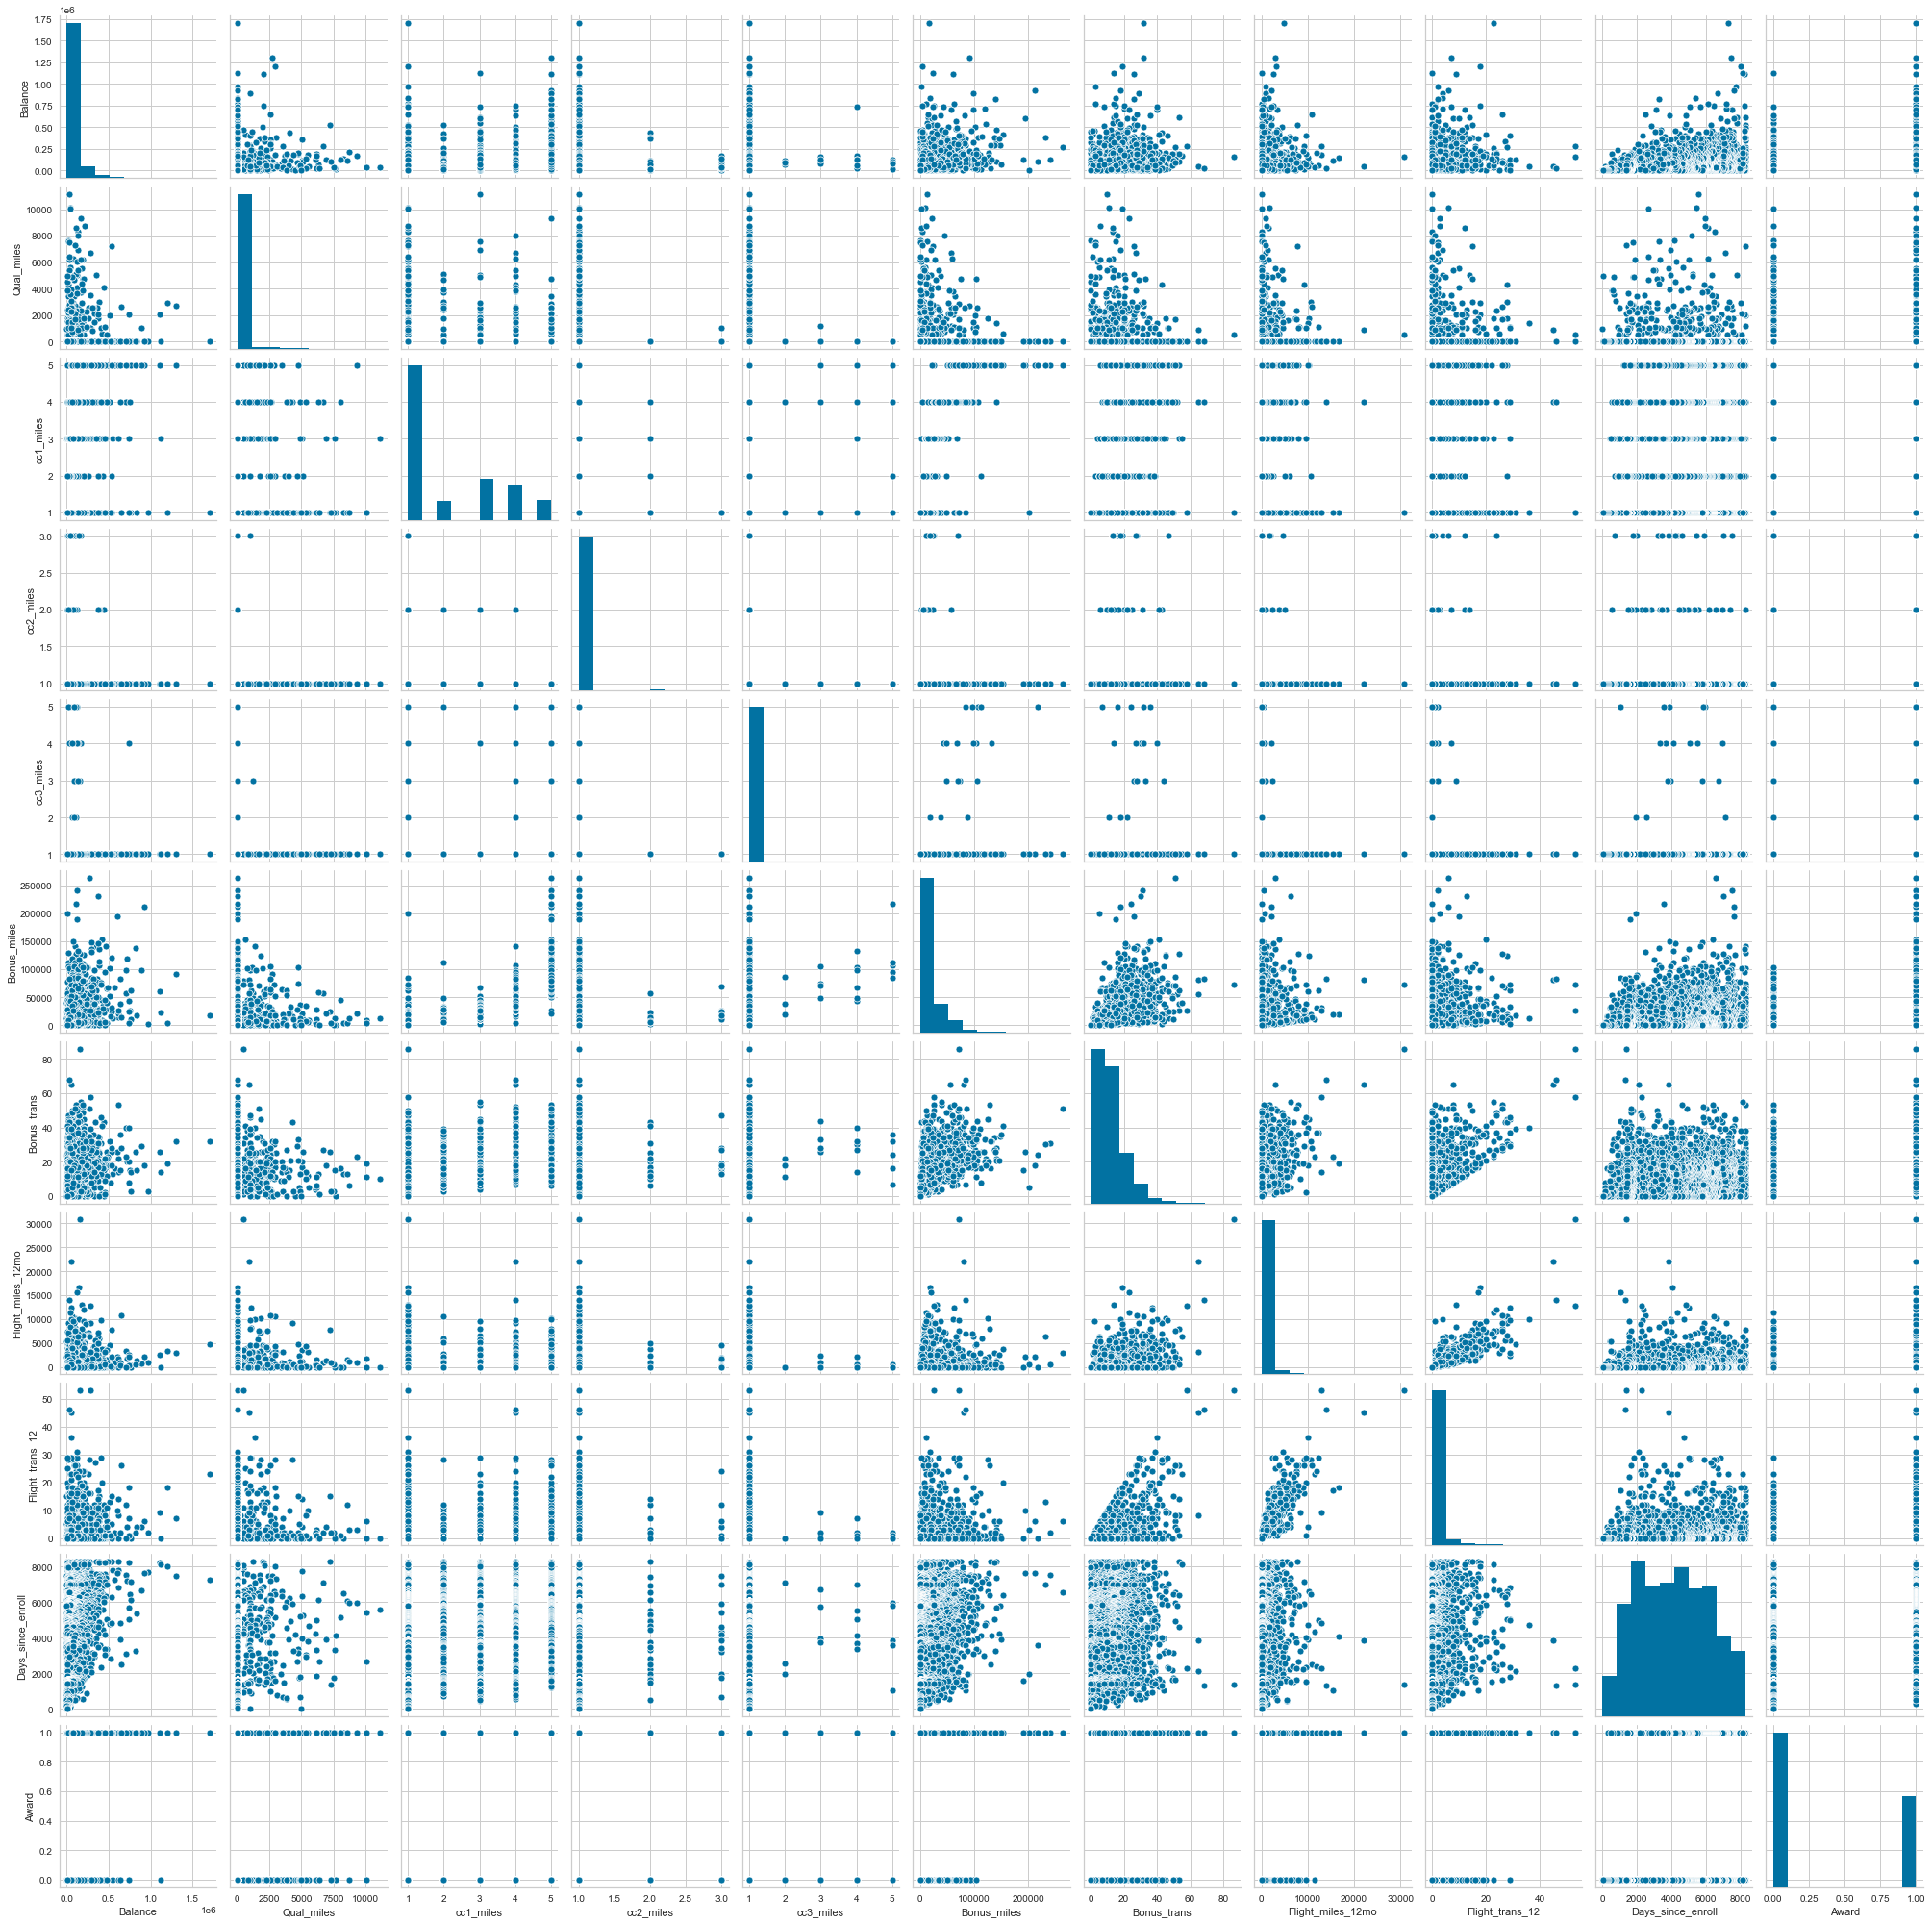

In [9]:
sns.pairplot(data)

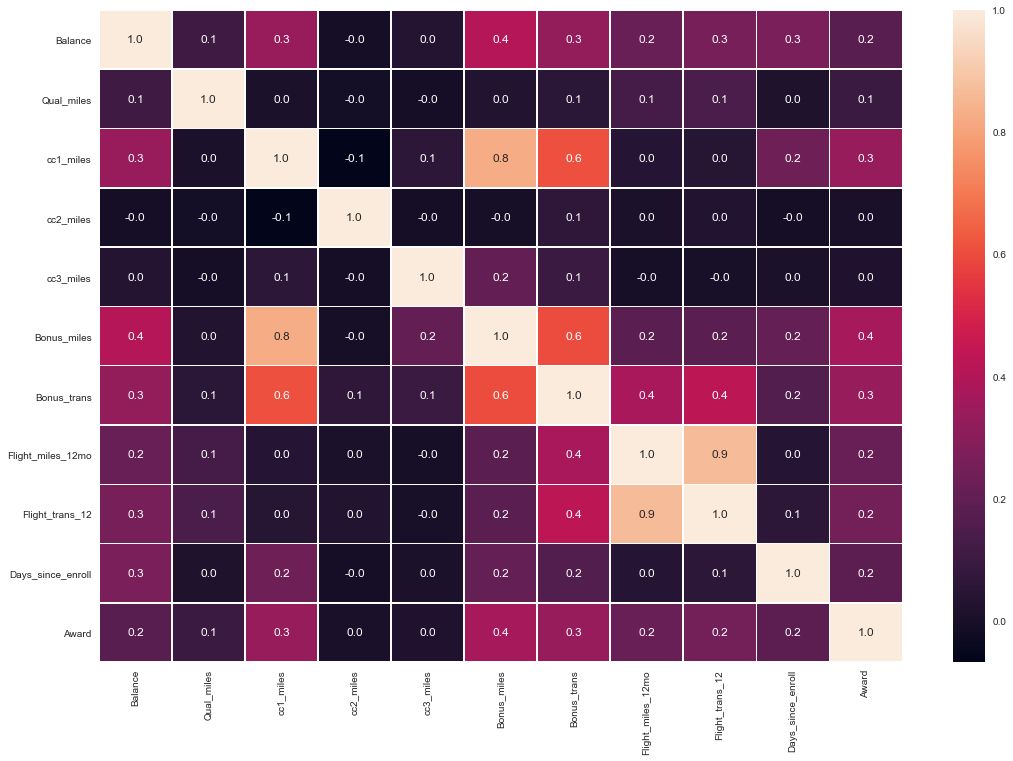

In [10]:
# correlation heatmap

f,ax = plt.subplots(figsize=(18,12))
sns.heatmap(data.corr(), annot=True, linewidths =.5, fmt ='.1f',ax=ax)
plt.show()

In [11]:
# Standardizing the Data
standard_scaler = StandardScaler()
std_df = standard_scaler.fit_transform(data)
std_df.shape

(3999, 11)

#### KMeans Clustering

In [12]:
cluster_range = range(1,15)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters,n_init=10)
    clusters.fit(std_df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)
    
clusters_df = pd.DataFrame({"num_clusters":cluster_range,"cluster_errors":cluster_errors})
clusters_df

,num_clusters,cluster_errors
0,1,43989.000000
1,2,35409.516630
2,3,30899.216409
3,4,27154.040724
4,5,23701.224567
5,6,21090.115217
6,7,18893.427490
7,8,17316.753604
8,9,16043.980062
9,10,14730.503959


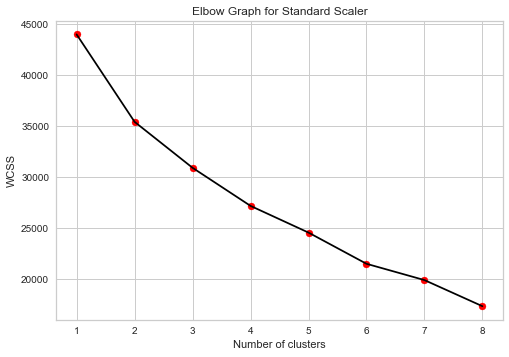

In [13]:
# within-cluster sum-of-squares criterion 
# Use Elbow Graph to find optimum number of  clusters (K value) from K values range
# The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion WCSS 
# random state can be anything from 0 to 42, but the same number to be used everytime,so that the results don't change. 

wcss=[]
for i in range(1,9):
    kmeans=KMeans(n_clusters=i,random_state=2)
    kmeans.fit(std_df)
    wcss.append(kmeans.inertia_)
    
# Plot K values range vs WCSS to get Elbow graph for choosing K (no. of clusters)
plt.plot(range(1,9),wcss,color = 'black')
plt.scatter(range(1,9),wcss,color='red')
plt.title('Elbow Graph for Standard Scaler')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

As seen from the elbow graph, the slope changes at 2. However, since spltting the dataset into 2 groups would not be very beneficial, we further evaluate clusters for higher values of k.

#### Build KMeans Cluster algorithm using K=6 

In [14]:
# model building using cluster numbers = 6

model_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
y_predict_kmeans = model_kmeans.fit_predict(std_df)
y_predict_kmeans.shape

(3999,)

In [15]:
# these are nothing but cluster labels...

y_predict_kmeans

array([2, 2, 2, ..., 1, 2, 2])

In [16]:
model_kmeans.labels_

array([2, 2, 2, ..., 1, 2, 2])

In [17]:
# cluster centres associated with each lables

model_kmeans.cluster_centers_

array([[ 1.13686833,  0.4142613 ,  0.1345493 , -0.09824189, -0.06276658,
         0.65640088,  1.70548646,  3.77107713,  4.00212558,  0.27153799,
         0.88395812],
       [ 0.43381284, -0.11301262,  1.21014978, -0.09824189, -0.05449778,
         0.92813517,  0.75269133, -0.08065818, -0.08956555,  0.37079373,
         0.57854007],
       [-0.29444721, -0.12883455, -0.60151188, -0.09824189, -0.06071593,
        -0.51682757, -0.4934919 , -0.18636264, -0.19845942, -0.19791068,
        -0.34993321],
       [-0.04688966, -0.1562356 , -0.66822727,  9.03825361, -0.06276658,
        -0.10166533,  0.61785114,  0.0875494 ,  0.22034681, -0.07246398,
         0.05178388],
       [ 0.63971926, -0.08443292,  1.0220844 , -0.09824189, 15.64629931,
         3.17969131,  1.71461374,  0.03329269,  0.05969539,  0.23987261,
         0.33752735],
       [ 0.45710365,  6.73109194, -0.04322862, -0.09824189, -0.06276658,
         0.06371677,  0.06535804,  0.3596938 ,  0.39424679, -0.07122344,
         0.387

In [18]:
# within-cluster sum of squared

# The lower values of inertia are better and zero is optimal.
# Inertia is the sum of squared error for each cluster. 
# Therefore the smaller the inertia the denser the cluster(closer together all the points are)

model_kmeans.inertia_

21089.973628929645

In [19]:
#Assign clusters to the data set
df = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')
df.rename({'ID#':'ID', 'Award?':'Award'}, inplace=True, axis=1)
df['Kmeans_label'] = model_kmeans.labels_

In [20]:
# Group data by Clusters (K=6)
df.groupby('Kmeans_label').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Kmeans_label,,,,,,,,,,,,
0,1743.867133,188155.664336,464.573427,2.244755,1.000000,1.000000,32995.580420,27.979021,5739.692308,16.552448,4679.251748,0.797203
1,1599.831858,117176.916331,58.446500,3.720837,1.000000,1.001609,39485.872084,18.811746,346.617860,1.032180,4887.485921,0.649236
2,2233.860465,43882.372895,43.558140,1.229751,1.000000,1.000401,4644.210104,6.852847,199.160385,0.621091,3706.378508,0.200882
3,2269.372093,68876.581395,23.255814,1.139535,2.348837,1.000000,14689.837209,17.534884,582.627907,2.209302,3968.930233,0.395349
4,1664.866667,138061.400000,78.800000,3.466667,1.000000,4.066667,93927.866667,28.066667,506.666667,1.600000,4613.866667,0.533333
5,2057.295082,119660.491803,5351.065574,2.000000,1.000000,1.000000,18683.475410,12.229508,963.639344,2.868852,3971.491803,0.557377


#### Hierarchical Clustering Algorithm

#### 7.1 Dendogram on MinMaxScaler Applied on Dataset<a class="anchor" id="7.1"></a>

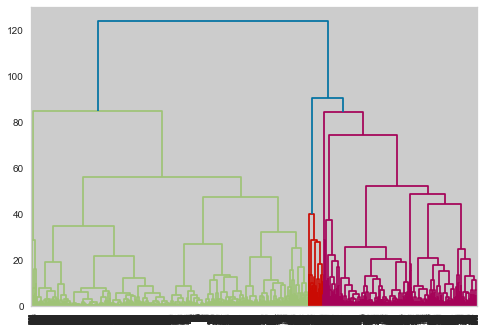

In [21]:
Dendrogram1 = sch.dendrogram(sch.linkage(std_df, method = "ward",optimal_ordering=False))

In [22]:
hie_cluster1 = AgglomerativeClustering(n_clusters=3,linkage="ward")
hie_labels1 = hie_cluster1.fit_predict(std_df)

In [23]:
df_cluster = pd.DataFrame(hie_labels1,columns=['Clusters'])
df_cluster.head()

,Clusters
0,0
1,0
2,0
3,0
4,1


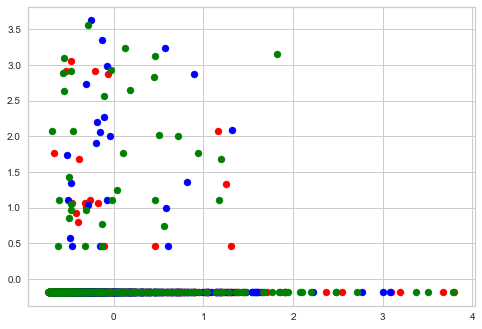

In [24]:
plt.scatter(std_df[labels==0, 0], std_df[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(std_df[labels==1, 0], std_df[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(std_df[labels==2, 0], std_df[labels==2, 1], s=50, marker='o', color='green')

#### DBSCAN

In [25]:
from itertools import product

eps_values = np.arange(0.25,3,0.25) # eps values to be investigated
min_samples = np.arange(3,23) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [26]:
dbscan = DBSCAN(eps=2.5, min_samples=21)
dbscan.fit(std_df)

DBSCAN(eps=2.5, min_samples=21)

In [27]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
# -1 are the noise points in our dataset and the rest are the clusters

# Concating Labels with main dataset copy

df['DBSCAN_labels'] = dbscan.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,DBSCAN_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,2,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,2,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,2,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,2,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,1,0


In [29]:
df.groupby('DBSCAN_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
DBSCAN_labels,,,,,,,,,,,,,
-1,1708.947115,211990.889423,1522.576923,2.509615,1.278846,1.235577,45335.081731,24.754808,3276.389423,9.548077,4768.596154,0.687500,2.038462
0,2031.601688,66008.336587,68.482722,2.034819,1.000000,1.000000,15598.138486,10.880243,305.532577,0.925086,4082.893959,0.352941,1.662094


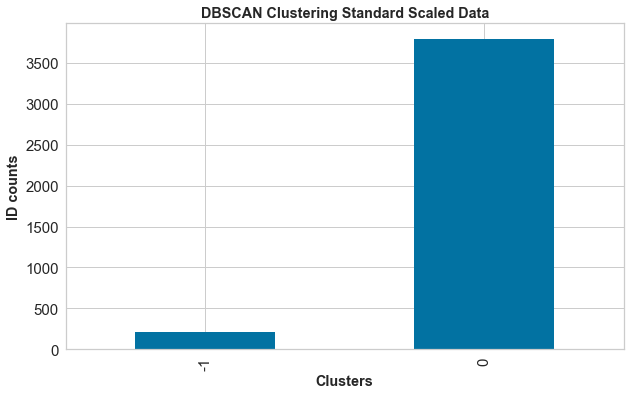

In [30]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['DBSCAN_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('DBSCAN Clustering Standard Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [31]:
# Sorting elements based on cluster label assigned and taking average for insights.

cluster1 = pd.DataFrame(df.loc[df.DBSCAN_labels==0].mean(),columns= ['Cluster1_avg'])
cluster2 = pd.DataFrame(df.loc[df.DBSCAN_labels==1].mean(),columns= ['Cluster2_avg'])

In [32]:
avg_df = pd.concat([cluster1,cluster2],axis=1)
avg_df

,Cluster1_avg,Cluster2_avg
ID,2031.601688,NaN
Balance,66008.336587,NaN
Qual_miles,68.482722,NaN
cc1_miles,2.034819,NaN
cc2_miles,1.000000,NaN
cc3_miles,1.000000,NaN
Bonus_miles,15598.138486,NaN
Bonus_trans,10.880243,NaN
Flight_miles_12mo,305.532577,NaN
Flight_trans_12,0.925086,NaN


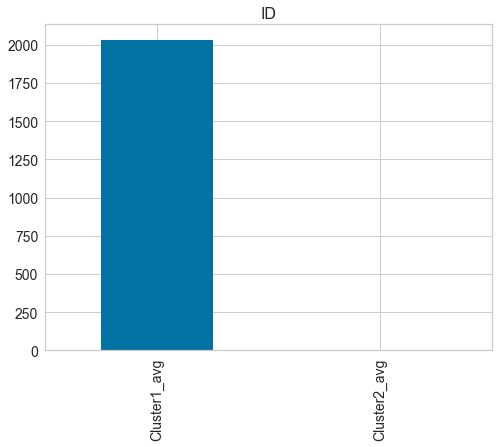

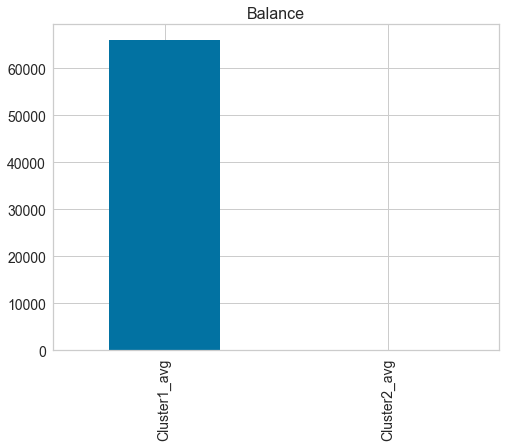

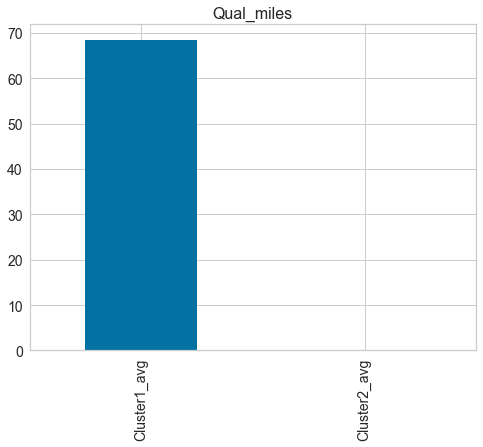

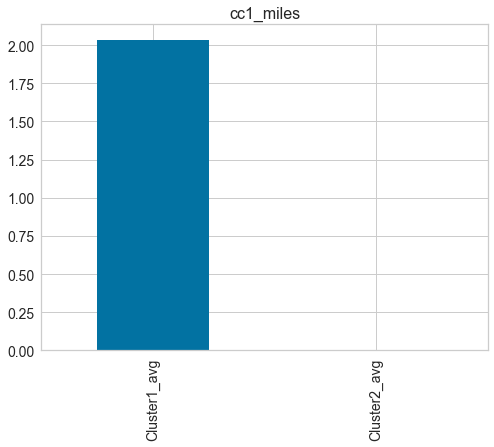

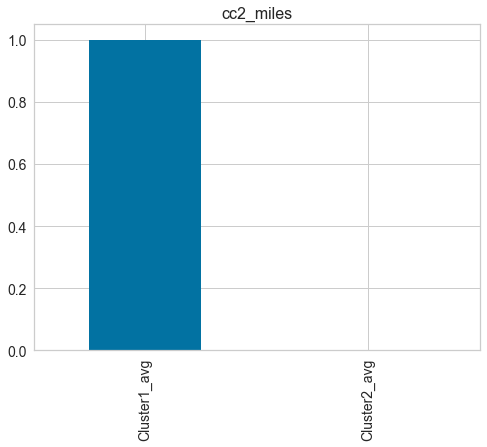

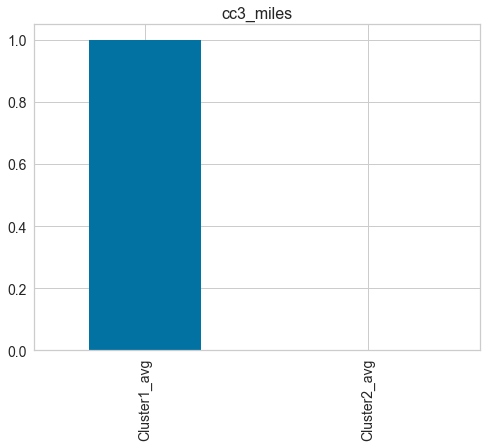

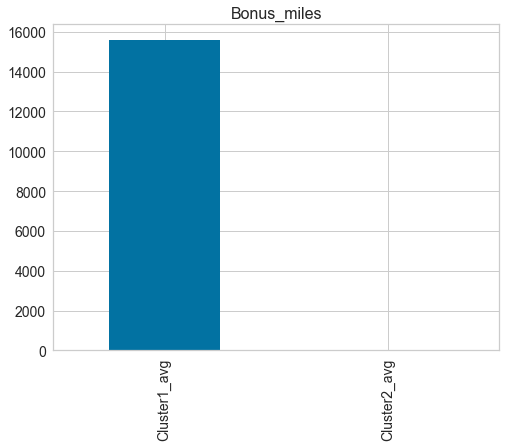

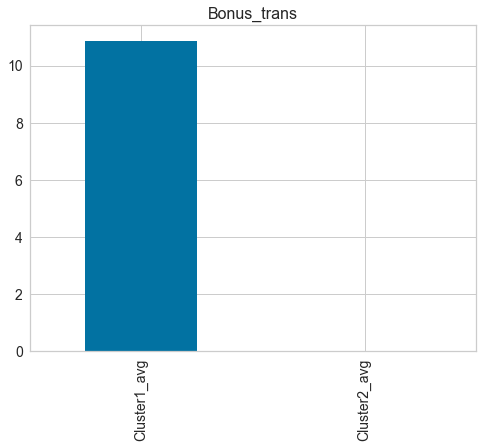

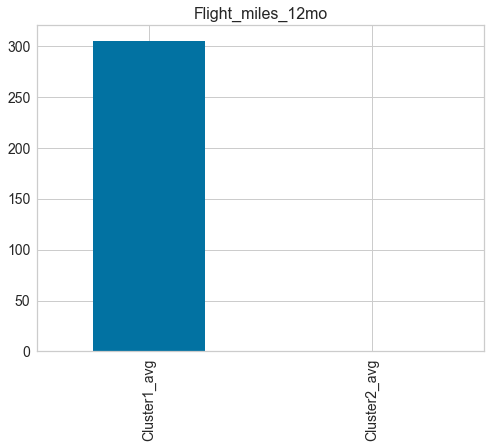

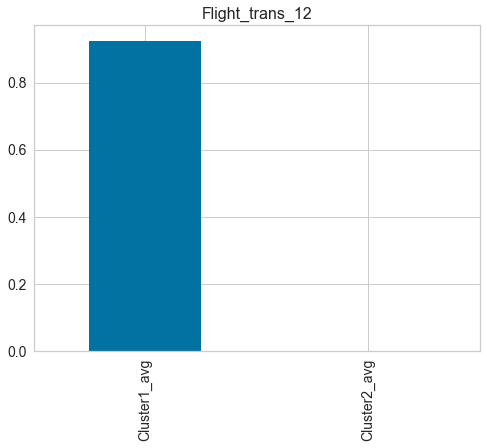

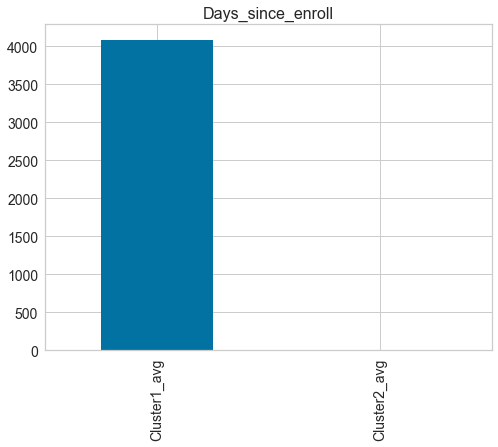

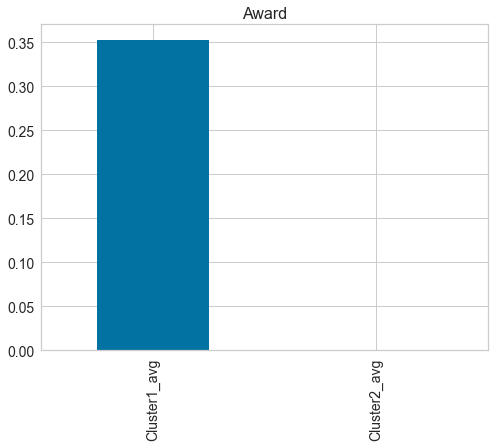

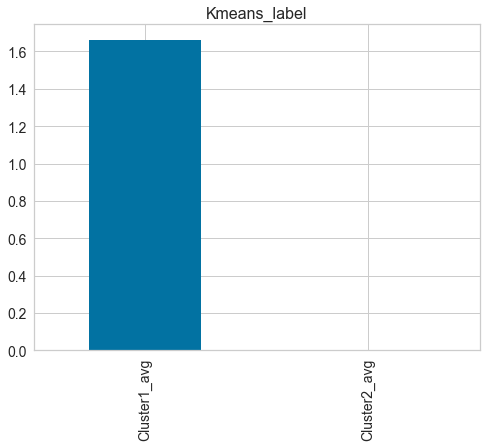

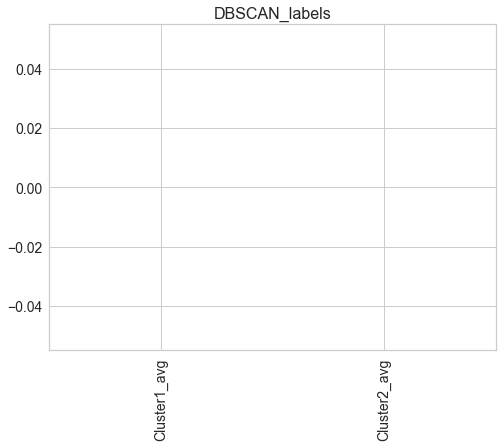

In [33]:
# Extract and plot one Column data .xs method
for i , row in avg_df.iterrows():
    fig = plt.subplots(figsize=(8,6))
    j = avg_df.xs(i ,axis = 0)
    plt.title(i, fontsize=16, fontweight=20)
    j.plot(kind='bar',fontsize=14)
    plt.show()
    print()